In [1]:
import librosa
import librosa.display as dp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import csv
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft
from tqdm import tqdm
import soundfile as sf
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [56]:
y, sr = librosa.load('data/a/asteria-soyes_loyal-12-of_a_rose_singe_we_anon-59-88.mp3', sr=None)
y.dtype

dtype('float32')

In [61]:
y, sr = sf.read('wav/asteria-soyes_loyal-12-of_a_rose_singe_we_anon-59-88.wav')
y.dtype

dtype('float64')

In [67]:
np.random.randint(1000)

567

In [72]:
# create dataset

class MagnaTagATune(Dataset):
    '''
    Later: add download + prepare data into chunks of 3 sec bits on disk that we can read.
    '''
    def __init__(self):
        self.data = [] # fnames, load on the fly
        
        targets = {}
        with open('data/annotations_final.csv') as f:
            csvreader = csv.reader(f, delimiter='\t')
            j = 0
            for i, row in enumerate(csvreader):
                if i == 0:
                    continue
                tags = [int(x) for x in row[1:-1]]
                if max(tags) == 0:
                    continue # skip those with no labels (about 16% of data)
                label = np.argmax(tags)  # tags are unique (max==1)
                fname = row[-1].split('/')[-1].split('.mp3')[0]
                targets[fname] = label

        
        for root, _, fnames in os.walk('wav'):
            for fname in fnames:
                fname = fname.split('.wav')[0]
                if fname not in targets:
                    continue
                
                label = targets[fname]
                self.data.append((os.path.join(root, fname), label))  
    
    def __getitem__(self, index):
        # Only get 3 seconds from each clip for now
        fname, target = self.data[index]
        y, sr = sf.read(fname + '.wav')
        #  get random 3 second chunk
        num_frames = 3 * sr # 3 second chunks
        start_idx = np.random.randint(len(y) - num_frames - 1)
        data = y[start_idx:start_idx + num_frames]  # 3 seconds, only this chunk for now
        data = data.reshape(1, -1).astype('float32')  # add in channel dimension
        return data, target
    
    def __len__(self):
        return len(self.data)
    
dataset = MagnaTagATune()

In [73]:
loader = DataLoader(dataset, batch_size=40, num_workers=1)

In [64]:
for data, target in loader:
    print(data)
    break

tensor([[[ 0.0000,  0.0000,  0.0000,  ..., -0.0156, -0.0156, -0.0156]],

        [[ 0.0000,  0.0000,  0.0000,  ..., -0.0156, -0.0156, -0.0156]],

        [[ 0.0000, -0.0078,  0.0000,  ..., -0.0234,  0.0000,  0.0312]],

        ...,

        [[ 0.0000, -0.0078,  0.0000,  ..., -0.2734, -0.2656, -0.2656]],

        [[ 0.0000, -0.0078,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -0.0078,  0.0000,  ...,  0.0078,  0.0078,  0.0000]]])


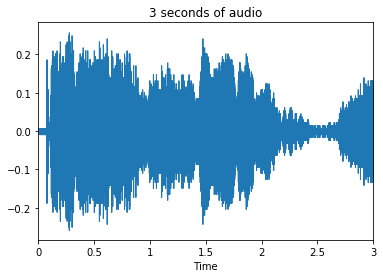

In [35]:
num_frames = 3 * sr  # 3 seconds
dp.waveplot(y[:num_frames], sr=sr);
plt.title('3 seconds of audio');

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y[:num_frames])), ref=np.max)
dp.specshow(D, y_axis='linear', cmap='gray_r');
plt.colorbar(format='%+2.0f dB');

In [ ]:
for batch_idx, (data, target) in enumerate(loader):
    print(data.shape)
    print(target.shape)
    break

In [ ]:
conv1 = nn.Conv1d(1, 32, kernel_size=1024, stride=1024)
x = torch.Tensor(y.reshape(1, 1, -1)).to(device) # add in batch and channel dims

# what if we make a network that just overfits to 3 seconds of data where the output is a filtered version of the input?
# can we visualise the kernels?

In [ ]:
print(data.shape)

In [ ]:
for p in conv1.parameters():
    print(p.numel())  # 1024 * 32 + 32 total parameters

In [113]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=1024, stride=1024)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=8, stride=1, padding=3) # must have input channels matching output channels of previous
        self.pool = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=8, stride=1, padding=3)
        self.fc1 = nn.Linear(32 * 2, 100)
        self.fc2 = nn.Linear(100, 188)
        
        
    def forward(self, x):
        # input length is 48000
        x = F.relu(self.conv1(x)) # 1 x 32 x 46
        x = F.relu(self.conv2(x)) # 1 x 32 x 45
        x = self.pool(x) # 1 x 32 x 11
        x = F.relu(self.conv3(x)) # 1 x 32 x 10
        x = self.pool(x) # 1 x 32 x 2
        
        x = x.view(-1, 32 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [114]:
device = torch.device("cuda")
net = ConvNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1)

In [ ]:
target = torch.zeros(1, dtype=torch.long)
target[0] = 5

# is tagging multiple instance problem or classification of single class?

data, target = x.to(device), target.to(device)
net 


# make sure accuracy goes up, and that dimensions are correct...

In [115]:
device = torch.device("cuda")
net.train()
for epoch in range(20):
    print('Epoch: ', epoch)
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        print('Batch idx: {}, loss: {}'.format(batch_idx, train_loss / (batch_idx+1)), end='\r')

Epoch:  0
Epoch:  1: 29, loss: 5.1674776554107665


KeyboardInterrupt: 

In [103]:
for p in net.named_parameters():
    if p[0] == 'conv1.weight':
        print(p[1].shape)
        t = p[1]

torch.Size([32, 1, 1024])


In [104]:
filters = t.data.cpu().numpy().squeeze()

In [105]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order = 6
fs = sr   # sample rate, Hz
cutoff = 400  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

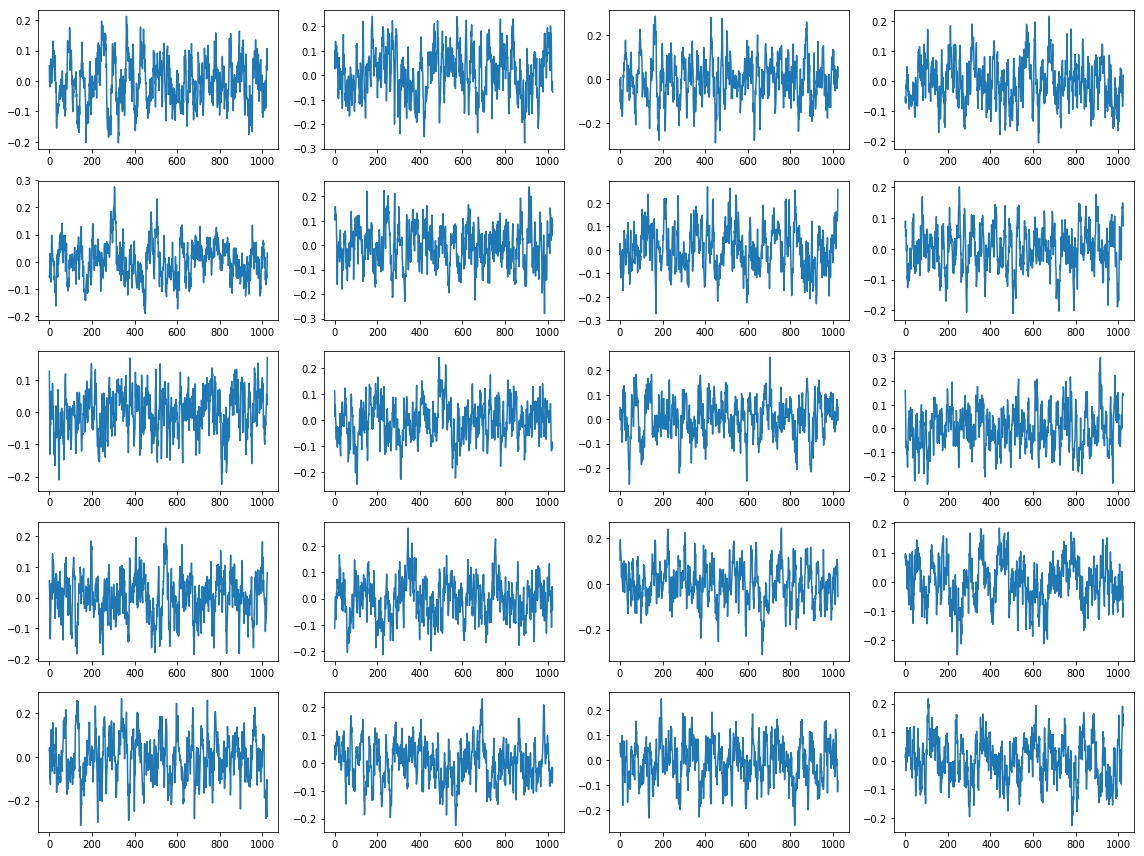

In [106]:
plt.figure(figsize=(16,12))
for i in range(20):
    plt.subplot(5, 4, i+1)
#     plt.plot(butter_lowpass_filter(filters[i], 400, sr, order));
#     plt.plot(filters[0,i]);
    plt.plot(filters[i]);

    
plt.tight_layout()

In [ ]:
plt.figure(figsize=(16,12))
for i in range(20):
    plt.subplot(5, 4, i+1)
    y = np.abs(fft(filters[i]))
    plt.plot(y[:512])
    
plt.tight_layout()